In [1]:
import os
os.chdir('..')
# print(os.getcwd()

In [2]:
import pandas as pd
import CustFun
import seaborn as sns
import joblib
sns.set_theme()

In [3]:
df = pd.read_csv('./preprocess/worldGame.csv',index_col=0)

### 透過sq(深蹲)和Rank(名次)重量來預測bp(臥推)+dl(硬舉)的試舉重量
### 適用情境：打破深蹲紀錄

<h>說明：根據規則破紀錄其它項目也必須要有成績才會被承認，此使用情境可幫助有意破紀錄的選手，提供其他項目試舉重量建議</h>

<h>拿掉 bp,dl,total 等欄位避免直接看答案</h>

In [4]:
df['bp_dl'] = df['bp'] + df['dl']
df = df.drop(columns=['bp','dl','total'])

In [5]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.2,random_state=20)

In [6]:
df_test[:10].to_csv('./API/sample.csv')

In [7]:
# 設定參數
params = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'dart',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'random_state':42
}

In [8]:
model,dic_metrics=CustFun.train(params,800,df_train,df_test,x_cols=df_train.drop(columns='bp_dl').columns,y_col='bp_dl')
display(dic_metrics['cv_mean'])
display(dic_metrics['full_dataset'])
display(dic_metrics['cv_var'])

rounds => 767
cv start
cv end


,metrics,train_baseline,train,test_baseline,val
0,mae,113.306000,9.815665,111.653163,22.303158
1,rmse,130.354048,12.643866,128.577091,29.183248
2,mape,0.290968,0.022862,0.286516,0.053233
3,r2_score,0.000000,0.990579,0.000000,0.947700
4,residual_P95,208.270028,23.807285,199.855754,46.609552
5,residual_P05,-187.729972,-15.703441,-187.144246,-47.443217
6,coverage_rate,0.912187,0.905063,0.908234,0.905060


,metrics,train_baseline,train,test_baseline,test
0,mae,113.444620,9.100232,119.341563,19.107473
1,rmse,130.472761,11.617900,132.629564,25.909353
2,mape,0.291329,0.021357,0.292483,0.045846
3,r2_score,0.000000,0.992071,0.000000,0.961838
4,residual_P95,207.764241,22.163476,211.543750,38.824041
5,residual_P05,-184.735759,-12.567232,-210.956250,-45.621082
6,coverage_rate,0.905063,0.905063,0.925000,0.900000


,metrics,train_baseline,train,test_baseline,val
0,mae,2.122050,5.354645e-02,37.148915,9.600792e+00
1,rmse,1.855978,2.443007e-01,28.066132,1.709945e+01
2,mape,0.000008,4.393555e-07,0.000183,3.484964e-05
3,r2_score,0.000000,5.567294e-07,0.000000,2.043031e-04
4,residual_P95,22.300685,3.838946e+00,278.620317,7.717572e+01
5,residual_P05,29.325774,6.750317e-02,512.231924,1.678437e+02
6,coverage_rate,0.000041,2.834069e-08,0.000048,4.428855e-07


## 預測結果：
<h>透過用平均值為baseline的預測值進行比較，可以從coverage_rate看出目前未預測成功的可能為離群值</h>

### 下圖發現team的部分類別有零星雜訊
<h>將數量小於等於5合併成一個類別以減少複雜度</h>

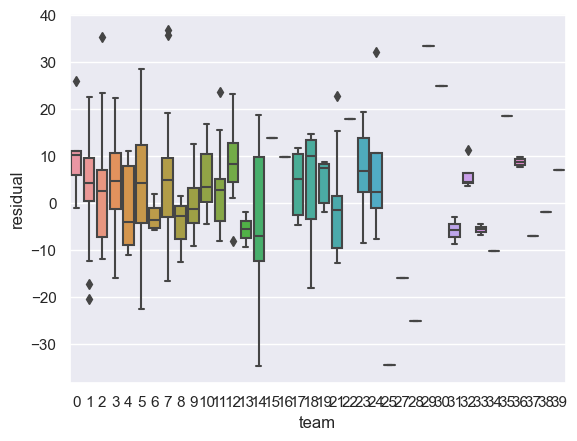

In [9]:
CustFun.show_residual_plot(df_train,model,'bp_dl','team')

### 透過oneway ANOVA 比較目標變數平均值差異性
<h>發現小於等於13 P-value 最小</h>

In [10]:
from scipy import stats

df1 = df_train.copy()
df2 = df_test.copy()
for i in range(15):
    d = df_train.team.value_counts().to_frame('count')
    lst = d.loc[d['count']>i].index.tolist()
    # print(lst)
    df1['team'] = df1['team'].apply(lambda t: t if t in lst else 99)
    df2['team'] = df2['team'].apply(lambda t: t if t in lst else 99)

    groups = [df1[df1['team'] == cat]['bp_dl'] for cat in df1['team'].unique()]
    f_stat, p_value = stats.f_oneway(*groups)  # ANOVA檢定
    print(i,f"P-value: {p_value}")

0 P-value: 0.0003374148172276311
1 P-value: 0.0003159703762096419
2 P-value: 0.0010333816395753082
3 P-value: 0.0006314572883674752
4 P-value: 0.0016504267989495521
5 P-value: 0.0011402717179603368
6 P-value: 0.00102804822466949
7 P-value: 0.00102804822466949
8 P-value: 0.0009699374856120427
9 P-value: 0.0005057636054865983
10 P-value: 0.0023419564841108487
11 P-value: 0.001192336643449015
12 P-value: 0.0005840320619808262
13 P-value: 0.0002659637581026201
14 P-value: 0.0003585549867946535


### 合併
<h>將team數量小於等於13的合併成一個類別以減少複雜度</h>

In [11]:
df = df_train['team'].value_counts().to_frame('count')
lst_team_stay_label = df.loc[df['count']>13].index.tolist()
print(lst_team_stay_label)
df_train['team'] = df_train['team'].apply(lambda t: t if t in lst_team_stay_label else 99)
df_test['team'] = df_test['team'].apply(lambda t: t if t in lst_team_stay_label else 99)

[7, 2, 3, 1, 5, 11]


In [12]:
import shap

### 過濾雜訊
<h>從部分相依圖可以看見rank在9之後預測結果沒有差異直接統一變成9</h>

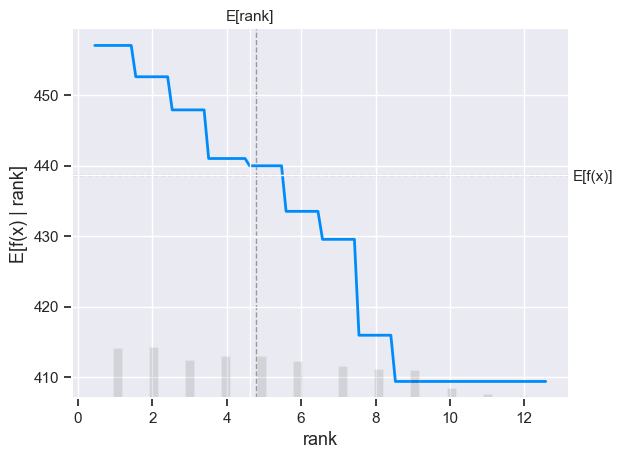

In [13]:
shap.partial_dependence_plot(
    "rank",
    model.predict,
    df_train.drop(columns='bp_dl'),
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [14]:
df_train.loc[df_train['rank']>=9,['rank']]=9
df_test.loc[df_test['rank']>=9,['rank']]=9

In [15]:
model1,dic_metrics=CustFun.train(params,800,df_train,df_test,x_cols=df_train.drop(columns='bp_dl').columns,y_col='bp_dl',using_cv=True)
display(dic_metrics['cv_mean'])
display(dic_metrics['full_dataset'])

rounds => 767
cv start
cv end


,metrics,train_baseline,train,test_baseline,val
0,mae,113.306000,9.984297,111.653163,22.254327
1,rmse,130.354048,12.826702,128.577091,28.829845
2,mape,0.290968,0.023248,0.286516,0.053028
3,r2_score,0.000000,0.990306,0.000000,0.949212
4,residual_P95,208.270028,23.823049,199.855754,49.087549
5,residual_P05,-187.729972,-16.147331,-187.144246,-47.287184
6,coverage_rate,0.912187,0.905063,0.908234,0.905060


,metrics,train_baseline,train,test_baseline,test
0,mae,113.444620,9.299296,119.341563,18.476402
1,rmse,130.472761,11.847398,132.629564,25.161487
2,mape,0.291329,0.021934,0.292483,0.044364
3,r2_score,0.000000,0.991755,0.000000,0.964009
4,residual_P95,207.764241,23.211779,211.543750,38.280765
5,residual_P05,-184.735759,-13.889858,-205.956250,-47.257419
6,coverage_rate,0.905063,0.905063,0.912500,0.900000


In [16]:
params2 = {
    'objective': 'regression',
    'metric': 'mae',
    'boosting_type': 'gbdt',
    'learning_rate': 0.08,
    'num_leaves': 31,
    'verbose': -1,
    'random_state':42
}

In [17]:
model2,dic_metrics=CustFun.train(params2,500,df_train,df_test,x_cols=df_train.drop(columns='bp_dl').columns,y_col='bp_dl')
display(dic_metrics['cv_mean'])
display(dic_metrics['full_dataset'])

rounds => 210
cv start
cv end


,metrics,train_baseline,train,test_baseline,val
0,mae,113.306000,9.304430,111.653163,23.166697
1,rmse,130.354048,12.153817,128.577091,30.855755
2,mape,0.290968,0.022277,0.286516,0.055706
3,r2_score,0.000000,0.991284,0.000000,0.941848
4,residual_P95,208.270028,19.443207,199.855754,48.202037
5,residual_P05,-187.729972,-19.128631,-187.144246,-52.156796
6,coverage_rate,0.912187,0.905063,0.908234,0.905060


,metrics,train_baseline,train,test_baseline,test
0,mae,113.444620,8.552953,119.341563,19.810293
1,rmse,130.472761,11.404069,132.629564,25.915236
2,mape,0.291329,0.020865,0.292483,0.047225
3,r2_score,0.000000,0.992360,0.000000,0.961821
4,residual_P95,207.764241,17.562714,211.543750,37.740386
5,residual_P05,-184.735759,-17.622918,-205.956250,-48.203243
6,coverage_rate,0.905063,0.905063,0.912500,0.912500


In [18]:
CustFun.metrics([model1,model2],df_train,df_test,
                df_train.drop(columns='bp_dl'),df_train['bp_dl'],
                df_test.drop(columns='bp_dl'),df_test['bp_dl'],
                df_train.drop(columns='bp_dl').columns,'bp_dl')

,train_baseline,train,test_baseline,test
mae,113.444620,8.698414,119.341563,18.573612
rmse,130.472761,11.254635,132.629564,25.109067
mape,0.291329,0.020887,0.292483,0.044243
r2_score,0.000000,0.992559,0.000000,0.964159
residual_P95,207.764241,20.387246,211.543750,38.010575
residual_P05,-184.735759,-15.756388,-205.956250,-47.730331
coverage_rate,0.905063,0.905063,0.912500,0.925000


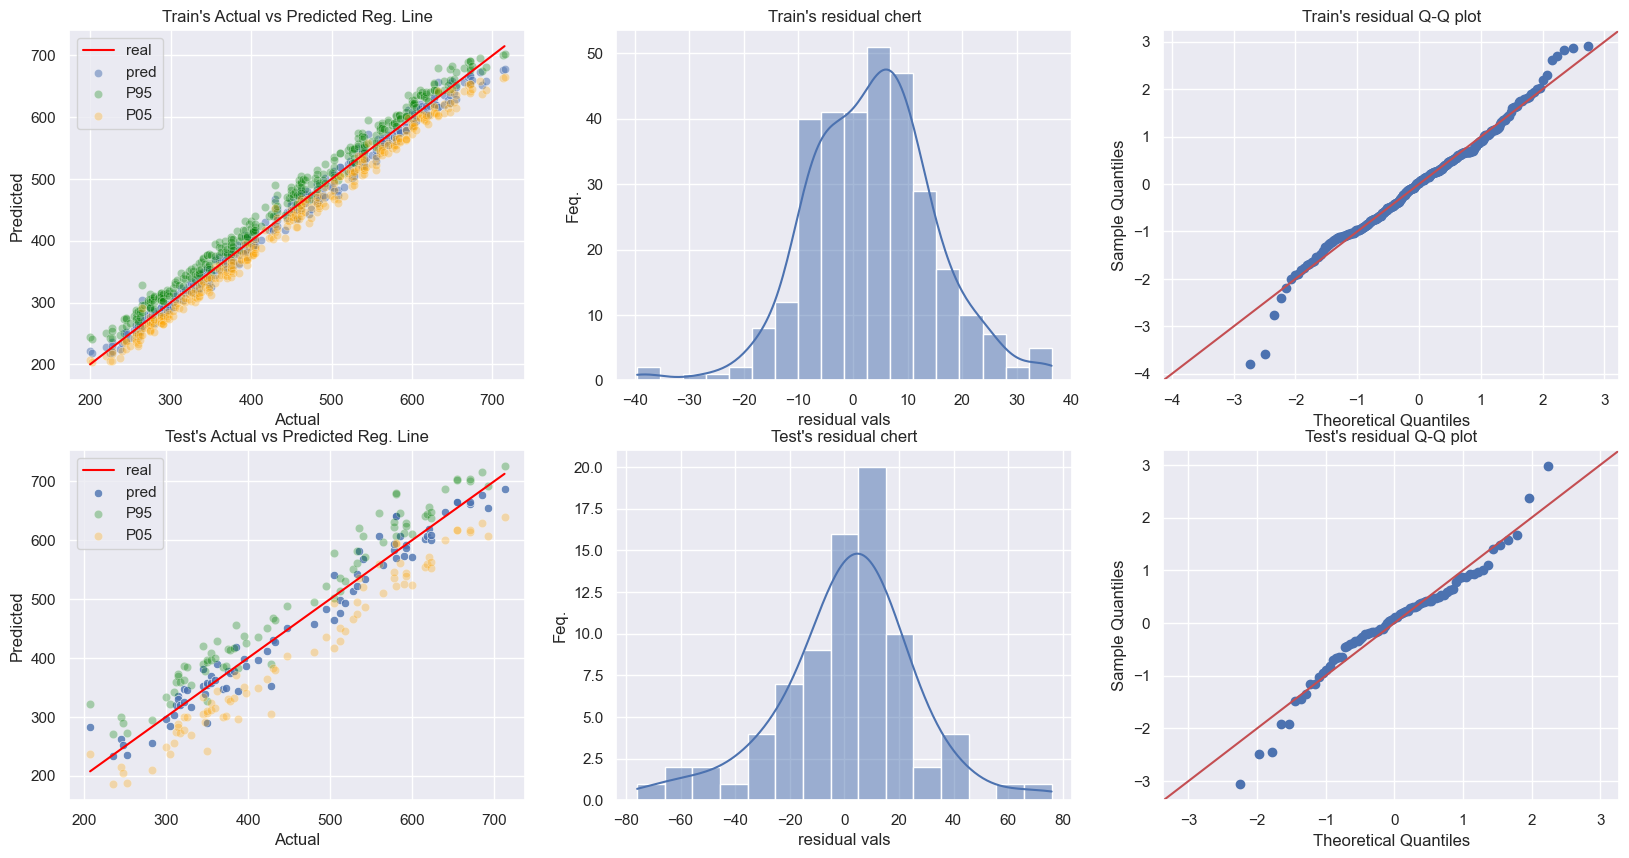

In [19]:
y_train = df_train['bp_dl']
lgbm_train_pred = model1.predict(df_train.drop(columns='bp_dl'))
y_test = df_test['bp_dl']
lgbm_test_pred = model1.predict(df_test.drop(columns='bp_dl'))

upper_train,lower_train = CustFun.compute_pi(df_train,model1,df_train.drop(columns='bp_dl').columns.tolist(),'bp_dl')
upper_test,lower_test = CustFun.compute_pi(df_test,model1,df_test.drop(columns='bp_dl').columns.tolist(),'bp_dl')

lower_train_pred = lgbm_train_pred+lower_train
upper_train_pred = lgbm_train_pred+upper_train
lower_test_pred = lgbm_test_pred+lower_test
upper_test_pred = lgbm_test_pred+upper_test

CustFun.resultPlot(y_train,lgbm_train_pred,y_test,lgbm_test_pred,lower_train_pred,upper_train_pred,lower_test_pred,upper_test_pred)

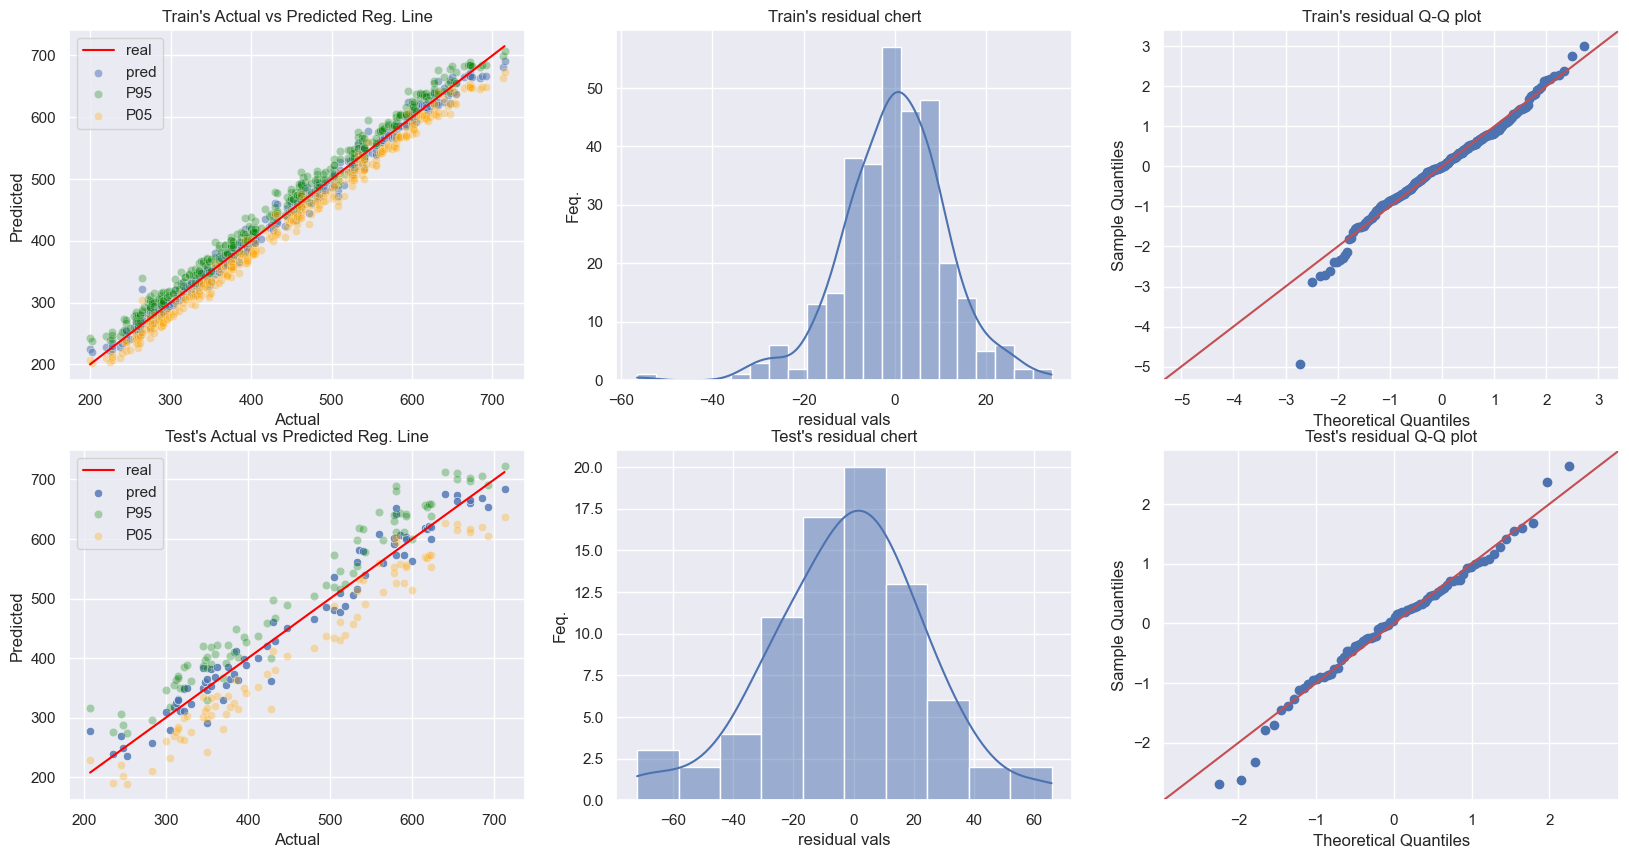

In [20]:
y_train = df_train['bp_dl']
lgbm_train_pred = model2.predict(df_train.drop(columns='bp_dl'))
y_test = df_test['bp_dl']
lgbm_test_pred = model2.predict(df_test.drop(columns='bp_dl'))

upper_train,lower_train = CustFun.compute_pi(df_train,model2,df_train.drop(columns='bp_dl').columns.tolist(),'bp_dl')
upper_test,lower_test = CustFun.compute_pi(df_test,model2,df_test.drop(columns='bp_dl').columns.tolist(),'bp_dl')

lower_train_pred = lgbm_train_pred+lower_train
upper_train_pred = lgbm_train_pred+upper_train
lower_test_pred = lgbm_test_pred+lower_test
upper_test_pred = lgbm_test_pred+upper_test

CustFun.resultPlot(y_train,lgbm_train_pred,y_test,lgbm_test_pred,lower_train_pred,upper_train_pred,lower_test_pred,upper_test_pred)

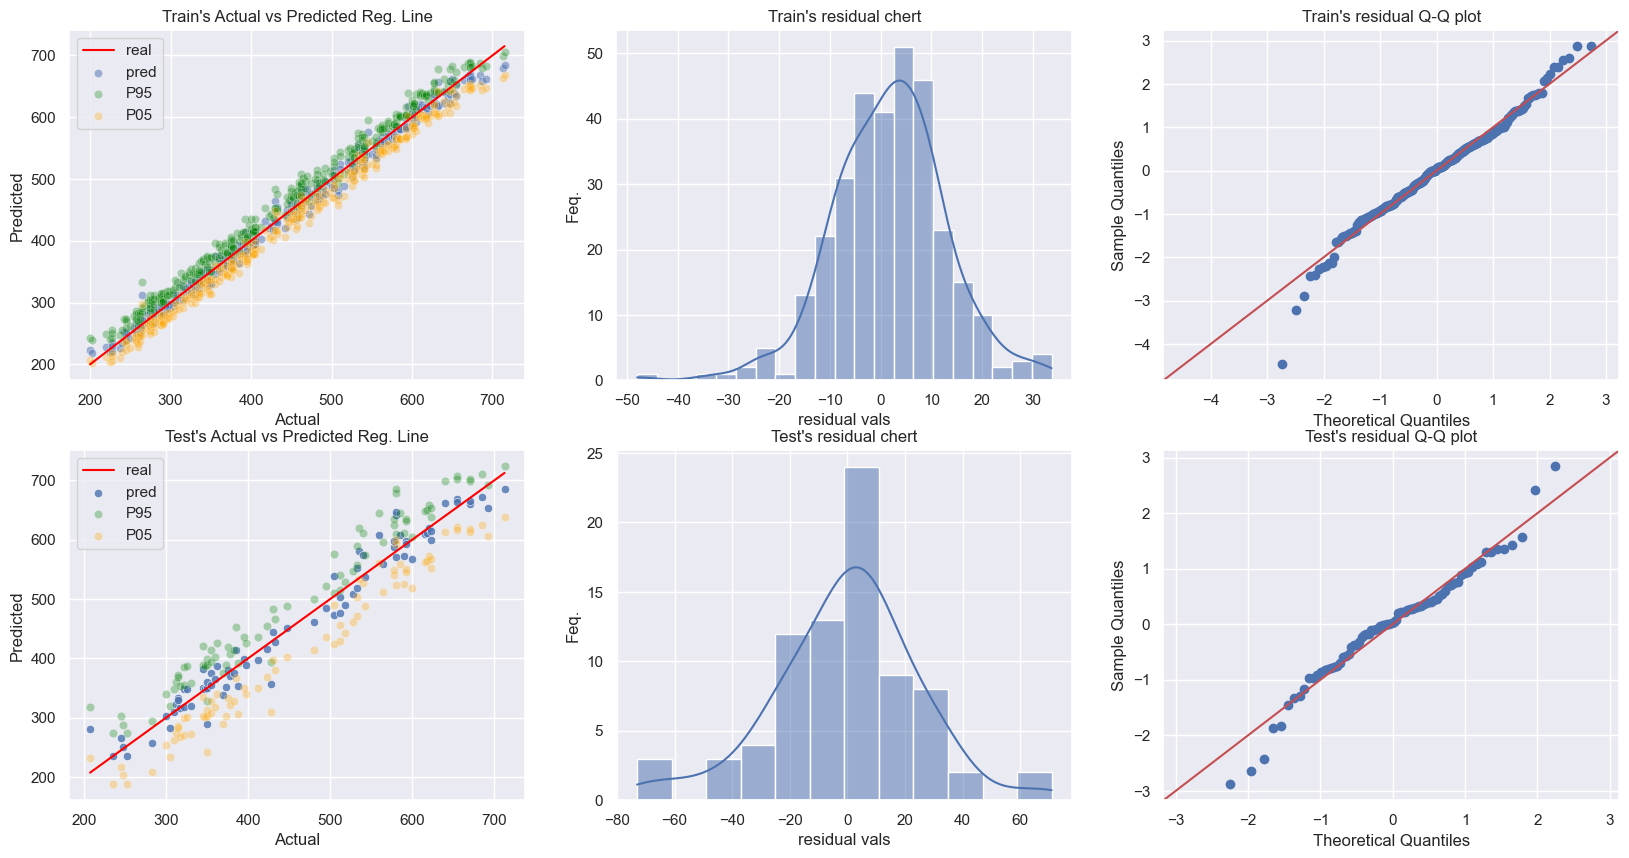

In [21]:
y_train = df_train['bp_dl']
lgbm_train_pred = (model1.predict(df_train.drop(columns='bp_dl'))+model2.predict(df_train.drop(columns='bp_dl')))/2
y_test = df_test['bp_dl']
lgbm_test_pred = (model1.predict(df_test.drop(columns='bp_dl'))+model2.predict(df_test.drop(columns='bp_dl')))/2

upper_train1,lower_train1 = CustFun.compute_pi(df_train,model1,df_train.drop(columns='bp_dl').columns.tolist(),'bp_dl')
upper_train2,lower_train2 = CustFun.compute_pi(df_train,model2,df_train.drop(columns='bp_dl').columns.tolist(),'bp_dl')
upper_train = (upper_train1+upper_train2)/2
lower_train = (lower_train1+lower_train2)/2

upper_test1,lower_test1 = CustFun.compute_pi(df_test,model1,df_test.drop(columns='bp_dl').columns.tolist(),'bp_dl')
upper_test2,lower_test2 = CustFun.compute_pi(df_test,model2,df_test.drop(columns='bp_dl').columns.tolist(),'bp_dl')
upper_test = (upper_test1+upper_test2)/2
lower_test = (lower_test1+lower_test2)/2

lower_train_pred = lgbm_train_pred+lower_train
upper_train_pred = lgbm_train_pred+upper_train
lower_test_pred = lgbm_test_pred+lower_test
upper_test_pred = lgbm_test_pred+upper_test

CustFun.resultPlot(y_train,lgbm_train_pred,y_test,lgbm_test_pred,lower_train_pred,upper_train_pred,lower_test_pred,upper_test_pred)

In [22]:
joblib.dump(model1,'./API/model/lgbm_bp_dl_1.pkl')


['./API/model/lgbm_bp_dl_1.pkl']

In [23]:
joblib.dump(model2,'./API/model/lgbm_bp_dl_2.pkl')

['./API/model/lgbm_bp_dl_2.pkl']

In [35]:
df_90PI = pd.DataFrame()
upper_test1,lower_test1 = CustFun.compute_pi(df_test,model1,df_test.drop(columns='bp_dl').columns.tolist(),'bp_dl')
upper_test2,lower_test2 = CustFun.compute_pi(df_test,model2,df_test.drop(columns='bp_dl').columns.tolist(),'bp_dl')

df_90PI['model1_upper'] = [upper_test1]
df_90PI['model1_lower'] = [lower_test1]

df_90PI['model2_upper'] = [upper_test2]
df_90PI['model2_lower'] = [lower_test2]

df_90PI['mean_lower']  = [(lower_test1+lower_test2)/2]
df_90PI['mean_upper']  = [(upper_test1+upper_test2)/2]

df_90PI['team_stay_label'] = [','.join(str(x) for x in lst_team_stay_label)]

df_90PI.to_csv('./API/model/90PI.csv')